In [121]:
from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import argparse
import unet2d
import pandas as pd
import SimpleITK as sitk
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy.stats
import imageio

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--input_dir', type=str, default='/raid/COVID-19/CT-severity/processed/dataset/')
parser.add_argument('--include', type=str, default='medseg_1')

parser.add_argument('--restore_dir', type=str, 
                    default='/raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9_scale_0.5/')
parser.add_argument('--checkpoint', type=str, default='49')

parser.add_argument('--device', type=str, default='0')
parser.add_argument('--batch_size', type=int, default=16)

net = unet2d.unet2d()
parser = net.add_to_parser(parser)

In [123]:
if sys.argv[0] != 'test_mseg_external.py':
    args = parser.parse_args(['--device', '1', '--n_class', '3', 
#                               '--checkpoint', '4',
                              '--restore_dir', '/raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9.5_scale_1.25/'
#                               '--restore_dir', '/raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_1.0_scale_-1/'
                             ])
else:
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', vars(args)[k])

layers = 5
fc_nodes = [1024]
finetune_scope = finetune
filter_size = 3
input_dir = /raid/COVID-19/CT-severity/processed/dataset/
keep_prob = 1.0
pool_size = 2
n_class = 3
dice_smooth = 1
batch_size = 16
input_shape = [256, 256, 7]
checkpoint = 49
up_layers = 0
device = 1
restore_dir = /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9.5_scale_1.25/
include = medseg_1
fc_drop = [0.25]
features_root = 32


In [124]:
# build network
os.environ['CUDA_VISIBLE_DEVICES'] = args.device
tf.reset_default_graph()
model = unet2d.unet2d()
model.from_args(args)
model.build_unet_mask()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# restore
loader = tf.train.Saver()
loader.restore(sess, os.path.join(args.restore_dir, args.checkpoint))

INFO:tensorflow:Restoring parameters from /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9.5_scale_1.25/49


In [125]:
def load_dataset(input_dir, cohort, exclude_set = []):
    inds = [int(os.path.basename(s)[:-len('.npz')]) for s in glob.glob(os.path.join(input_dir, '*.npz'))]
    inds = [d for d in inds if d not in exclude_set]
    
    if len(inds) == 0:
        return None
    
    dataset = {}
    for index in inds:
        f = np.load(os.path.join(input_dir, '%d.npz'%index))
        for k in f:
            if k not in dataset:
                dataset[k] = []
            dataset[k].append(f[k])
    
    for k in dataset:
        dataset[k] = np.concatenate(dataset[k])
    dataset['cohort'] = np.array([cohort] * len(dataset[dataset.keys()[0]]))
    
    return dataset

In [126]:
# get studying cohorts
include_cohort = args.include.split(',')
print (include_cohort)
cohorts = [os.path.basename(s) for s in glob.glob(os.path.join(args.input_dir, '*')) if os.path.basename(s) in include_cohort and os.path.isdir(s)]
print (cohorts)

['medseg_1']
['medseg_1']


In [127]:
# loading data
data_list = []
for cohort in cohorts:
    print ('loading %s'%cohort)
    d = load_dataset(os.path.join(args.input_dir, cohort, 'npzs', 'with_unet_pred'), cohort)
    if d is not None:
        data_list.append(d)
dataset = {}
for k in data_list[0]:
    dataset[k] = np.concatenate([d[k] for d in data_list])

loading medseg_1


In [128]:
# load patient information
patient_infos = {}
for cohort in cohorts:
    if os.path.exists(os.path.join(args.input_dir, cohort, 'patient_types.npy')):
        info = np.load(os.path.join(args.input_dir, cohort, 'patient_types.npy'), allow_pickle=True).item()
        for k in info:
            info[k]['cohort'] = cohort
        patient_infos.update(info)

# load exclusion
df = []
for cohort in cohorts:
    if os.path.exists(os.path.join(args.input_dir, cohort, 'mrn_train.csv')):
        df.append(pd.read_csv(os.path.join(args.input_dir, cohort, 'mrn_train.csv')))
if len(df) == 0:
    mrn_to_exclude = []
else:
    mrn_to_exclude = list(pd.concat(df, ignore_index=True).filename)
print (mrn_to_exclude)

[]


In [129]:
def get_patient_data_mrn(mrn, dataset, patient_infos):
    patient = {}
    
    inds = np.where(dataset['mrns'] == mrn)[0]
    
    for k in dataset:
        patient[k] = dataset[k][inds]
    if mrn in patient_infos:
        patient['info'] = patient_infos[mrn]
    else:
        patient['info'] = None
        
    return patient

In [130]:
def hard_dice(img, label):
    return 2 * np.sum(img * label, dtype = np.float32) / (np.sum(img) + np.sum(label) + 1e-4)

In [131]:
# predict all
preds = []
imgs = dataset['img']
masks = np.where(dataset['pred'] > 0.5, 1, 0)
print (imgs.shape[0])
for ibatch in range(0, imgs.shape[0], args.batch_size):
    if (ibatch // args.batch_size + 1) % 10 == 0:
        print (ibatch, end=',')
    batch_x = imgs[ibatch:ibatch+args.batch_size]
    batch_mask = masks[ibatch:ibatch+args.batch_size]
    pred = sess.run(model.pred, {model.X: batch_x, model.mask: batch_mask, model.phase: 0})

    preds.append(pred)
print ('concatenating pred')
preds = np.concatenate(preds)

dataset['pred_type'] = preds

407
144,304,concatenating pred


In [132]:
# record the type labels
dataset['pred_final'] = np.copy(dataset['pred'])
dataset['pred_final'][dataset['pred_final'] > 0.5] = 1
dataset['pred_final'][dataset['pred_type'] > 0.5] = 2

th = (1024 - 200) / 110.0
dataset['pred_th'] = np.copy(dataset['pred'])
dataset['pred_th'][dataset['pred_th'] > 0.5] = 1
con_th = np.where(imgs[..., [3]] > th, 1, 0) * masks[...,[0]]
dataset['pred_th'][con_th == 1] = 2

In [133]:
# calculate dice
label_con = np.where(dataset['label'] == 2, 1, 0)
pred_con = np.where(dataset['pred_final'] == 2, 1, 0)
pred_con_th = np.where(dataset['pred_th'] == 2, 1, 0)
dice_pred_con = hard_dice(label_con, pred_con)
print (dice_pred_con)

# threshold dice
dice_th_con = hard_dice(label_con, con_th)
print (dice_th_con)

0.46124763606021735
0.5300540329233202


In [134]:
masks_label = np.where(dataset['label'] > 0, 1, 0)
sensitivity = np.sum(masks_label * pred_con * label_con, dtype=np.float32) / np.sum(masks_label * label_con)
sensitivity_th = np.sum(masks_label * pred_con_th * label_con, dtype=np.float32) / np.sum(masks_label * label_con)
print (sensitivity, sensitivity_th)

specificity = np.sum(masks_label * (1-pred_con) * (1 - label_con), dtype=np.float32) / np.sum(masks_label-masks_label*label_con)
specificity_th = np.sum(masks_label * (1-pred_con_th) * (1 - label_con), dtype=np.float32) / np.sum(masks_label-masks_label*label_con)
print (specificity, specificity_th)

0.3180848542308604 0.4214268784072055
0.9983049905524064 0.994220295654107


In [135]:
# dialte the labels and see how the specificity changes
import scipy.ndimage

specificity_list = []
specificity_th_list = []

for drate in range(10):
    print (drate, end=',')
    
    label_dilated = []
    for label_slice in label_con:
        if drate == 0:
            label_dilated.append(label_slice[...,0])
        else:
            label_dilated.append(scipy.ndimage.morphology.binary_dilation(label_slice[...,0], iterations=drate))
    label_dilated = np.array(label_dilated)[..., np.newaxis]
    
    specificity = np.sum(masks_label * (1-pred_con) * (1 - label_dilated), dtype=np.float32) / np.sum(masks_label-masks_label*label_dilated)
    specificity_th = np.sum(masks_label * (1-pred_con_th) * (1 - label_dilated), dtype=np.float32) / np.sum(masks_label-masks_label*label_dilated)
    specificity_list.append(specificity)
    specificity_th_list.append(specificity_th)

0,1,2,3,4,5,6,7,8,9,

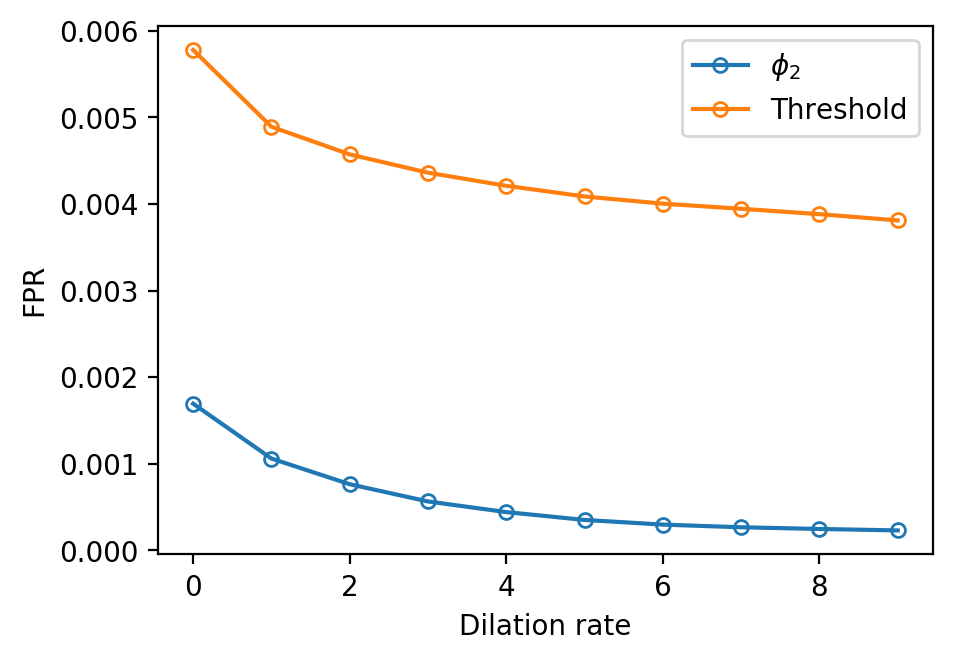

In [136]:
plt.figure(figsize=[5,3.5], dpi=200)
plt.plot(range(10), 1 - np.array(specificity_list), 'o-', markersize=5, fillstyle='none')
plt.plot(range(10), 1 - np.array(specificity_th_list), 'o-', markersize=5, fillstyle='none')
plt.xlabel('Dilation rate')
plt.ylabel('FPR')
plt.legend(['$\phi_2$', 'Threshold'])

In [137]:
# reformat to images
mrn_unique = np.unique(dataset['mrns'])

In [138]:
# calculate consolidation and severity
pred_cons_frac = []
pred_cons_frac_th = []
cons_frac = []
dice_cons = []
dice_cons_th = []
pred_severity_frac = []
severity_frac = []
dice_severity = []

print (len(mrn_unique))
for k, mrn in enumerate(mrn_unique):
    if (k+1) % 10 == 0:
        print (k, end=',')
    
    patient = get_patient_data_mrn(mrn, dataset, patient_infos)
    
    mask_area = float(patient['pred'].sum())
    lung_area = float(patient['lung'].sum())

    # consolidation
    label_cons = np.where(patient['label'] == 2, 1, 0).astype(np.float32)
    pred_cons = np.where(patient['pred_final'] == 2, 1, 0).astype(np.float32)
    pred_cons_th = np.where(patient['pred_th'] == 2, 1, 0).astype(np.float32)
    
    cons_frac.append(np.count_nonzero(label_cons) / lung_area)
    pred_cons_frac.append(np.count_nonzero(pred_cons) / lung_area)
    pred_cons_frac_th.append(np.count_nonzero(pred_cons_th) / lung_area)
    
    dice_cons.append(hard_dice(label_cons, pred_cons))
    dice_cons_th.append(hard_dice(label_cons, pred_cons_th))

    # overall
    label = np.where(patient['label'] > 0, 1, 0).astype(np.float32)
    pred = np.where(patient['pred_final'] > 0.01, 1, 0).astype(np.float32)
    
    severity_frac.append(np.count_nonzero(label) / lung_area)
    pred_severity_frac.append(np.count_nonzero(pred) / lung_area)
    dice_severity.append(hard_dice(label, pred))
    
pred_cons_frac = np.array(pred_cons_frac)
pred_cons_frac_th = np.array(pred_cons_frac_th)
cons_frac = np.array(cons_frac)
dice_cons = np.array(dice_cons)
dice_cons_th = np.array(dice_cons_th)
pred_severity_frac = np.array(pred_severity_frac)
severity_frac = np.array(severity_frac)
dice_severity = np.array(dice_severity)

9


In [139]:
pred_severity_frac

array([1.52053105e-01, 2.94976820e-02, 2.46776575e-02, 1.48718875e-01,
       1.29237382e-01, 2.23730330e-04, 1.18595158e-02, 2.97306497e-02,
       2.74275849e-01])

In [140]:
severity_frac

array([1.51897827e-01, 2.69439629e-02, 2.00700603e-02, 1.35708689e-01,
       7.03403784e-02, 7.99036894e-05, 6.34618994e-03, 1.54289126e-02,
       5.52296427e-01])

0.6212386140461629 0.2409670516422423
0.8335655869776976
SpearmanrResult(correlation=0.9500000000000001, pvalue=8.762523965086177e-05)


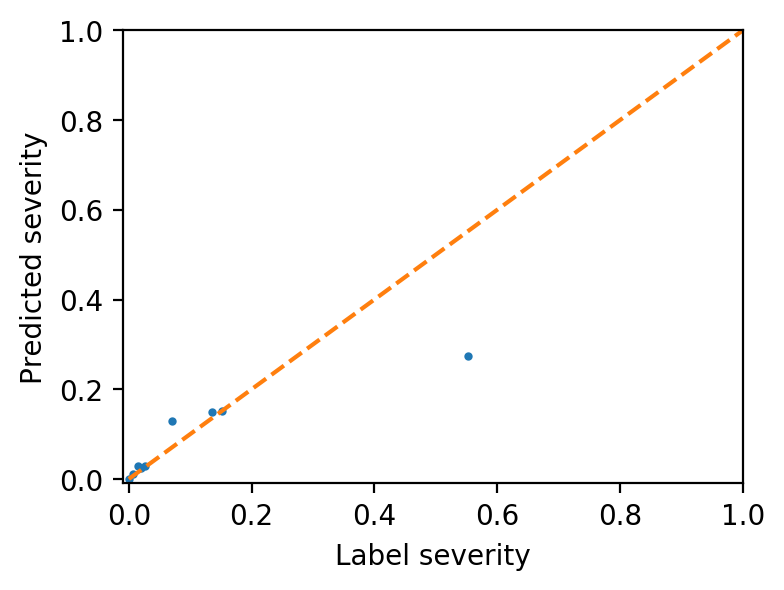

In [141]:
plt.figure(figsize = [4,3], dpi=200)
plt.plot(severity_frac, pred_severity_frac, 'o', markersize=2)
plt.xlabel('Label severity')
plt.ylabel('Predicted severity')
plt.xlim([-0.01,1])
plt.ylim([-0.01,1])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(severity_frac, pred_severity_frac)
plt.plot([0,1], [0,1], '--')
print (np.mean(dice_severity), np.std(dice_severity))
print (r_value**2)
print (scipy.stats.spearmanr(severity_frac, pred_severity_frac))

In [142]:
print (np.sqrt(np.mean((cons_frac - pred_cons_frac)**2)))
print (np.sqrt(np.mean((cons_frac - pred_cons_frac_th)**2)))

0.009496939978914163
0.0073690655564412995


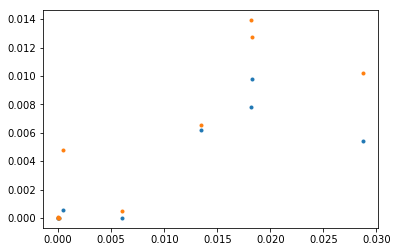

In [143]:
plt.plot(cons_frac, pred_cons_frac, '.')
plt.plot(cons_frac, pred_cons_frac_th, '.')

In [144]:
print (cons_frac)
print ((pred_cons_frac - cons_frac) / (cons_frac + 1e-6))
print ((pred_cons_frac_th - cons_frac) / (cons_frac + 1e-6))

[2.86846451e-02 1.81989600e-02 1.83013486e-02 6.01694293e-03
 1.34893883e-02 0.00000000e+00 0.00000000e+00 7.53310381e-05
 4.58821894e-04]
[-0.811756   -0.57084361 -0.46345122 -0.99983383 -0.54165899  0.
  0.         -0.98689917  0.21669942]
[-0.64405417 -0.23494528 -0.30411049 -0.9230409  -0.51640755  0.
 67.45026276 -0.84069189  9.41382605]


In [145]:
print (severity_frac)
print (dice_cons)
print (dice_cons_th)

[1.51897827e-01 2.69439629e-02 2.00700603e-02 1.35708689e-01
 7.03403784e-02 7.99036894e-05 6.34618994e-03 1.54289126e-02
 5.52296427e-01]
[0.28228491 0.58227486 0.67486539 0.         0.33564938 0.
 0.         0.         0.        ]
[0.36606526 0.80656343 0.75669383 0.0170052  0.31270358 0.
 0.         0.         0.01678445]


In [146]:
# show consolidation false positives: ind=-1, slice=25
# show consolidation true positives: ind=0, slice=25

ind = 0
mrn = mrn_unique[ind]
patient = get_patient_data_mrn(mrn, dataset, patient_infos)
print (mrn, patient['info'])

1 {'cohort': 'medseg_1', 'all_types': array([1, 2])}


In [147]:
patient['pred'].sum() / patient['lung'].sum()

0.14769873

In [148]:
def blend_ct_with_pred(ct_slice, pred_slice, alpha = 0.25, border = False):
    ct_blend = (ct_slice + 1150) / 1500.0 * 255
    ct_blend[ct_blend < 0] = 0
    ct_blend[ct_blend > 255] = 255
    ct_blend = np.tile(ct_blend, [1,1,3])
    
    if pred_slice is not None:
        mask_img = tf.keras.utils.to_categorical(pred_slice, 3)
        mask_img = mask_img[..., ::-1]
        mask_img[...,-1] = 0
        
        if border:
            alpha = 1
            mask_img[..., 1] = np.where(np.sum(mask_img, -1) > 0, 1, 0)
            mask_img[..., 0] = mask_img[..., 0] - scipy.ndimage.morphology.binary_erosion(mask_img[..., 0], iterations = 2)
            mask_img[..., 1] = mask_img[..., 1] - scipy.ndimage.morphology.binary_erosion(mask_img[..., 1], iterations = 2)
            mask_img[..., 1][mask_img[..., 0] > 0] = 0
        
        if alpha == 1:
            mask_sum = np.where(np.sum(mask_img,-1)>0, 1, 0)
            ct_blend[mask_sum==1, :] = 0
            ct_blend[mask_img == 1] = 255
        else:
            ct_blend = ct_blend * (1 - mask_img * alpha) + np.ones_like(ct_blend) * 255 * mask_img * alpha
    return ct_blend.astype(np.uint8)

def render_ct_img(patient, tag, alpha = 0.25):
    ct = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(args.input_dir, patient['info']['cohort'], 'ct_origin', mrn+'.nii')))
#     ct = scipy.ndimage.zoom(ct, [1,0.5,0.5], order=1)
    ct = ct[:, ::-1, :]
    pred_img = scipy.ndimage.zoom(patient[tag][:, ::-1, :, 0], [1,2,2], order=0)
    label_img = scipy.ndimage.zoom(patient['label'][:, ::-1, :, 0], [1,2,2], order=0)
    offset = patient['islice'][0] + 3
    
    ct_blends = []
    ct_label_blends = []
    
    print (ct.shape[0])
    for islice in range(ct.shape[0]):
        if (islice + 1) % 10 == 0:
            print (islice, end = ',')
        seg_slice = islice - offset
        if seg_slice >= 0 and seg_slice < pred_img.shape[0]:
            ct_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], pred_img[seg_slice, ...], alpha, True))
            ct_label_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], label_img[seg_slice, ...], alpha, True))
        else:
            ct_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], None))
            ct_label_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], None))
    
    return ct_blends, ct_label_blends, ct       

In [149]:
# save png images
# for i, mrn in enumerate(mrn_unique):
#     print ('%d/%d'%(i+1, len(mrn_unique)))
    
#     patient = get_patient_data_mrn(mrn, dataset, patient_infos)
#     cohort = patient['cohort'][0]
    
#     output_dir = os.path.join(args.input_dir, 'all_results', 'display', mrn)
# #     output_dir = os.path.join(args.input_dir, cohort, 'result', 'display', mrn)
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
    
#     ct_display, _ = render_ct_img(patient)
#     for k, img in enumerate(ct_display):
#         imageio.imwrite(os.path.join(output_dir, 'IMAG_%s.png'%str(k+1).zfill(4)), img)

In [150]:
ct_display, ct_label, ct = render_ct_img(patient, 'pred_final')
ct_th, ct_label, ct = render_ct_img(patient, 'pred_th')

45
9,19,29,39,45
9,19,29,39,

1


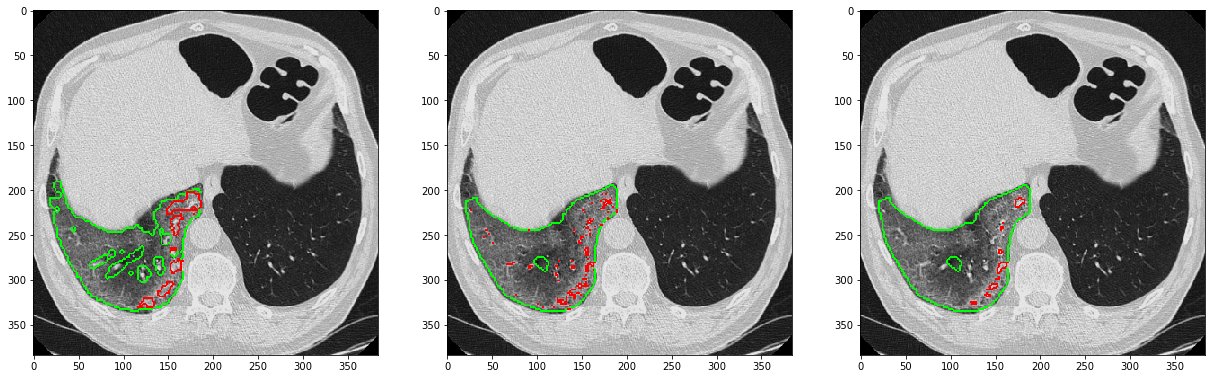

In [151]:
display_slice = 8
print (mrn)
plt.figure(figsize=[21,7])
plt.subplot(131); plt.imshow(ct_label[display_slice][64:-64, 64:-64])
plt.subplot(132); plt.imshow(ct_th[display_slice][64:-64, 64:-64])
plt.subplot(133); plt.imshow(ct_display[display_slice][64:-64, 64:-64])

In [33]:
# ct_img = ct[display_slice][64:-64, 64:-64]
# ct_img = (ct_img + 1150) / 1500.0 * 255
# ct_img[ct_img < 0] = 0
# ct_img[ct_img > 255] = 255
# ct_img = ct_img.astype(np.uint8)
# imageio.imwrite('images/external_%d_%d_ct.png'%(ind, display_slice), ct_img)

In [34]:
# imageio.imwrite('images/external_%d_%d_label.png'%(ind, display_slice), ct_label[display_slice][64:-64, 64:-64, :])
# imageio.imwrite('images/external_%d_%d_th.png'%(ind, display_slice), ct_th[display_slice][64:-64, 64:-64, :])
# imageio.imwrite('images/external_%d_%d_pred.png'%(ind, display_slice), ct_display[display_slice][64:-64, 64:-64, :])
# imageio.imwrite('images/external_%d_%d_no_prior.png'%(ind, display_slice), ct_display[display_slice][64:-64, 64:-64, :])

In [42]:
for k in patient:
    print (k)

info
cohort
mrns
img
pred
label
lung
islice
pred_type
pred_final
pred_th
annotation


In [98]:
lung_mask = np.copy(patient['lung'][display_slice - 3, ::-1, :, 0][32:-32, 32:-32])
img = np.copy(patient['img'][display_slice - 3, ::-1, :, 3][32:-32, 32:-32])
label = np.where(patient['label'][display_slice - 3, ::-1, :, 0][32:-32, 32:-32] > 0, 1, 0)
pred = np.copy(patient['pred'][display_slice - 3, ::-1, :, 0][32:-32, 32:-32])
pred_type = np.copy(patient['pred_type'][display_slice - 3, ::-1, :, 0][32:-32, 32:-32])

In [103]:
def get_label(preds, imgs, masks, class_labels, bias, scale):
    # prior probabilities of being consolidation
    if scale <= 0:
        pred_cons = bias
    else:
        pred_cons = 1 / (1 + np.exp(-(imgs[..., [3]] + bias) * scale))
    pred_cons *= masks
    preds += pred_cons * 1
    preds[class_labels != 2, ...] = 0
    
    return np.where(preds > 0.5, 1, 0).astype(np.float32)

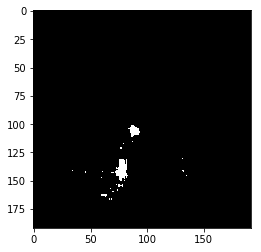

In [108]:
# calculate the prior map
bias = -9
scale = 0.5
prior_map = 1 / (1 + np.exp(-(img + bias) * scale))
plt.imshow(np.where(prior_map + pred_type > 0.5, 1, 0), 'gray', vmin=0, vmax=1)

In [62]:
img = img * 110 - 1024
img = (img + 1150) / 1500.0 * 255
img[img < 0] = 0
img[img > 255] = 255
img = img.astype(np.uint8)
imageio.imwrite('images/fig_1_mask.png', img)

In [120]:
label_img = label[...,np.newaxis] * 255
label_img = np.concatenate([np.zeros_like(label_img), label_img, np.zeros_like(label_img)], -1).astype(np.uint8)
imageio.imwrite('images/fig_1_label.png', label_img)

pred_img = pred[...,np.newaxis] * 255
pred_img = np.concatenate([pred_img, pred_img, np.zeros_like(pred_img)], -1).astype(np.uint8)
imageio.imwrite('images/fig_1_pred.png', pred_img)

type_img = pred_type[...,np.newaxis] * 255
type_img = np.concatenate([type_img, np.zeros_like(type_img), np.zeros_like(type_img)], -1).astype(np.uint8)
imageio.imwrite('images/fig_1_type_4.png', type_img)

cm = plt.cm.inferno
prior_img = cm(prior_map * 2)
imageio.imwrite('images/fig_1_prior.png', prior_img)

em_img = np.where(prior_map + pred_type > 0.5, 255, 0)[..., np.newaxis]
em_img = np.concatenate([em_img, np.zeros_like(em_img), np.zeros_like(em_img)], -1).astype(np.uint8)
imageio.imwrite('images/fig_1_em_4.png', em_img)

In [114]:
np.min(prior_img)

0.002249

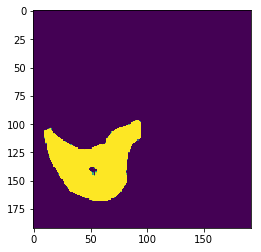

In [157]:
plt.imshow(pred_all)

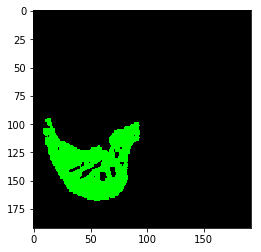

In [60]:
plt.imshow(label_img)